In [1]:
# Very intentionally construct input matrices myself - this ensures that the matrices are what I mean them to be.
# Can be effectively replaced with scikit-learn preprocessing methods.

# TODO: rename the onehot dicts to feature dicts

import os, sys, glob
import numpy as np
import scipy as sp
import copy
#import keras
import itertools as it

def pad_to_dimensions(array, dimensions):
    # Return a right-padded N-dimensional array to the specified dimensions
    # If a dimension is None, then padding is not done for that dimensions
    assert type(dimensions) == tuple, 'Dimensions must be a tuple.'
    assert len(array.shape) == len(dimensions), 'Mismatch between array dimension and number of dimensions provided.'
    pad_lengths = [requestDim - arrDim if requestDim != None else arrDim for arrDim, requestDim in zip(array.shape, dimensions)]
    assert all(i>=0 for i in pad_lengths), 'Array larger than provided dimensions.'
    pad_lengths_formatted = [(0, pad_length) for pad_length in pad_lengths]
    return np.pad(array, pad_lengths_formatted, mode='constant', constant_values=0)

def gen_onehot_dict_default(cohort):
    # Return an int -> vector map for each unique element in cohort of arrays
    # TODO: Should you zero out the case when an entry is 0, at least for the graph matrices???
    def genVector(entryNum, numEntries):
        onehot_vec = np.zeros((numEntries,))
        onehot_vec[entryNum] = 1
        return onehot_vec
    uniqueEntries = np.unique(np.concatenate([np.unique(array) for array in cohort]))
    numUniques = len(uniqueEntries)
    return {uniqueEntry: genVector(idx, numUniques) for idx, uniqueEntry in enumerate(uniqueEntries)}

def standardize_array_shapes(arrays):
    # Pad arrays to the same size
    array_shapes = [array.shape for array in arrays]
    dims = tuple([max(lengths) for lengths in zip(*[np.shape(array) for array in arrays])])
    return [pad_to_dimensions(array, dims) for array in arrays]
    
def make_onehot(cohort, onehot_dict=None, verbose=False):
    # Makes a cohort of arrays onehot, then pads arrays to the same size.
    # Returns (onehot dictionary, arrays)

    def gen_onehot(array, onehot_dict):
        # Should be parallelized for better performance
        extension_length = len(onehot_dict.values()[0])
        new_dims = tuple(list(array.shape) + [extension_length])
        onehot_array = np.zeros(new_dims)
        for index in np.ndindex(array.shape):
            onehot_index_full = tuple(list(index) + [None]) # Slice whole remaining dimension
            onehot_array[onehot_index_full] = onehot_dict[array[index]]
        return onehot_array

    if onehot_dict == None:
        onehot_dict = gen_onehot_dict_default(cohort)
    onehot_cohort = [gen_onehot(array, onehot_dict) for array in cohort]
    return onehot_dict, onehot_cohort

def readgraph(fname):
    # Returns a header/IntArray and matrix/IntArray. Assert header and matrix have same length.
    a = open(fname); b = a.readlines(); a.close()
    csv_as_float_2D = [map(float,i.strip().split(',')) for i in b]
    header = np.array(csv_as_float_2D[0])
    matrix = np.array(csv_as_float_2D[1:])
    return {'header':header, 'matrix':matrix}

def standardize_graphs(graphs, max_size=None, verbose=True):
    # Graphs is an iterable of dictionaries {'header': header, 'matrix': matrix}
    # Take in a N-length atom list, NxN matrix, assert all entries are in one-hot dictionaries
    if max_size == None:
        max_size = max(len(graph['header']) for graph in graphs)
        
    kept_graphs = [graph for graph in graphs if len(graph['header']) <= max_size]
    assert len(kept_graphs) > 0, 'No graphs are smaller than the provided max size'
    headers = [i['header'] for i in kept_graphs]
    matrices = [i['matrix'] for i in kept_graphs]
    headers_padded = standardize_array_shapes(headers)
    matrices_padded = standardize_array_shapes(matrices)
    connectivities = [(i!=0).astype(float) for i in matrices_padded]

    headers_onehot_dict, headers_new = make_onehot(headers_padded)
    matrices_onehot_dict, matrices_new = make_onehot(matrices_padded)
    
    outputGraphs = [{'header': header, 'matrix': matrix, 'connectivity': connectivity, 'origHeader': origHeader, 'origMatrix': origMatrix}
                    for header,matrix,connectivity,origHeader,origMatrix
                    in zip(headers_new, matrices_new, connectivities,headers_padded,matrices_padded)]
    
    if verbose:
        print 'Header One-Hot Map:', headers_onehot_dict
        print 'Bond One-Hot Map:', matrices_onehot_dict
        print 'Graph Size:', max_size
        print 'Number of dropped graphs:', len(graphs) - len(kept_graphs)
        
    return headers_onehot_dict, matrices_onehot_dict, outputGraphs

# Read in graphs
graph_files = glob.glob('qm9graph/*.csv')
mygraphs = [readgraph(fname) for fname in graph_files]
_, _, mygraphs_standardized = standardize_graphs(mygraphs, max_size=29)
headers_padded = np.array([i['header'] for i in mygraphs_standardized])
matrices_padded = np.array([i['matrix'] for i in mygraphs_standardized])
connectivies_padded = np.array([i['connectivity'] for i in mygraphs_standardized])
origHeaders_padded = np.array([i['origHeader'] for i in mygraphs_standardized])
origMatrices_padded = np.array([i['origMatrix'] for i in mygraphs_standardized])
print headers_padded.shape
print matrices_padded.shape
print connectivies_padded.shape

Header One-Hot Map: {0.0: array([1., 0., 0., 0., 0., 0.]), 1.0: array([0., 1., 0., 0., 0., 0.]), 6.0: array([0., 0., 1., 0., 0., 0.]), 7.0: array([0., 0., 0., 1., 0., 0.]), 8.0: array([0., 0., 0., 0., 1., 0.]), 9.0: array([0., 0., 0., 0., 0., 1.])}
Bond One-Hot Map: {0.0: array([1., 0., 0., 0.]), 1.0: array([0., 1., 0., 0.]), 2.0: array([0., 0., 1., 0.]), 3.0: array([0., 0., 0., 1.])}
Graph Size: 29
Number of dropped graphs: 0
(665, 29, 6)
(665, 29, 29, 4)
(665, 29, 29)


In [3]:
# Graph convolution model

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Need if Conda environment isn't resolved properly
import keras
import sklearn.model_selection
import keras.backend as K

def stacker(tensorList):
    # Stack the bond hidden vectors and atom hidden vectors (29x29x(2*size(atom hidden) + size(bond_hidden)))
    bond_hiddens = tensorList[0]
    atom_hiddens = tensorList[1]
    vertical_atom_hiddens = keras.backend.expand_dims(atom_hiddens,axis=2)
    vertical_atom_hiddens_horizontal = keras.backend.repeat_elements(vertical_atom_hiddens,29,2)
    horiz_atom_hiddens = keras.backend.expand_dims(atom_hiddens,axis=1)
    horiz_atom_hiddens_vertical = keras.backend.repeat_elements(horiz_atom_hiddens,29,1)
    
    big_hidden_boi = keras.backend.concatenate([vertical_atom_hiddens_horizontal, horiz_atom_hiddens_vertical, bond_hiddens], axis=3)
    return big_hidden_boi

def summer(tensorList):
    # Sums the message matrix (29x29x(size(message)))
    messages = tensorList[0]
    connectivity = tensorList[1]
    # Zero out all unconnected messages
    connectivity_expanded = keras.backend.expand_dims(connectivity, axis=3)
    # Add all messages horizontally (29xsize(message))
    filtered = messages*connectivity_expanded # note: * is element-wise, keras.dot is matrix multiplication
    summed_horiz = keras.backend.sum(filtered, axis=2)
    return summed_horiz

def image_categorical_crossentropy(y_true, y_pred):
    # Boilerplate off the internet to do crossentropy for multi-classification tasks,
    # in this case assigning one-hot atom labels to atoms
    __EPS = 1e-5
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

bond_hiddens_input = keras.layers.Input(shape=(29,29,4)) # For now, has the same dimension as bond feature vector
atom_hiddens_input = keras.layers.Input(shape=(29,6)) # For now, has the same dimension as atom feature vector
atom_hiddens_zeroed = keras.layers.Lambda(lambda x: x*0.0)(atom_hiddens_input) # For JP's exercise - eliminate atom info.
connectivity_input = keras.layers.Input(shape=(29,29))

message_stack = keras.layers.Lambda(stacker)([bond_hiddens_input, atom_hiddens_zeroed])

# You can use an NN on all 29*29 concatenated hidden vectors
#messages = keras.layers.Dense(30, activation='relu')(message_stack)

message_sum = keras.layers.Lambda(summer)([message_stack, connectivity_input])

# You can use an NN on all 29 messages (each message is a sum of incoming messages)
message_interpret = keras.layers.Dense(6, activation='tanh')(message_sum)

# Read out the atom identities
message_to_onehot = keras.layers.Dense(6, activation='softmax')(message_interpret)

model = keras.models.Model(inputs=[bond_hiddens_input, atom_hiddens_input, connectivity_input], outputs=message_to_onehot)

model.compile(optimizer='adam',
              loss=image_categorical_crossentropy,
              metrics=['mean_squared_error', 'mean_absolute_error','categorical_crossentropy'])

inputObjects = [[matrix, header, connectivity] for matrix, header, connectivity in zip(matrices_padded, headers_padded, connectivies_padded)]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputObjects, headers_padded, test_size=0.33)

model.fit(map(list,zip(*X_train)), y_train, epochs=300, verbose=True)

Epoch 1/300
445/445 [==============================] - 1s 3ms/step - loss: 0.4524 - mean_squared_error: 0.1406 - mean_absolute_error: 0.2775 - categorical_crossentropy: 1.7952
Epoch 2/300
445/445 [==============================] - 0s 311us/step - loss: 0.4421 - mean_squared_error: 0.1374 - mean_absolute_error: 0.2747 - categorical_crossentropy: 1.7452
Epoch 3/300
445/445 [==============================] - 0s 297us/step - loss: 0.4326 - mean_squared_error: 0.1344 - mean_absolute_error: 0.2718 - categorical_crossentropy: 1.6997
Epoch 4/300
445/445 [==============================] - 0s 297us/step - loss: 0.4238 - mean_squared_error: 0.1316 - mean_absolute_error: 0.2689 - categorical_crossentropy: 1.6580
Epoch 5/300
445/445 [==============================] - 0s 302us/step - loss: 0.4157 - mean_squared_error: 0.1289 - mean_absolute_error: 0.2661 - categorical_crossentropy: 1.6190 0s - loss: 0.4178 - mean_squared_error: 0.1296 - mean_absolute_error: 0.2668 - categorical_crossentropy: 1.62
Ep

445/445 [==============================] - 0s 297us/step - loss: 0.1288 - mean_squared_error: 0.0292 - mean_absolute_error: 0.0932 - categorical_crossentropy: 0.4607
Epoch 47/300
445/445 [==============================] - 0s 295us/step - loss: 0.1261 - mean_squared_error: 0.0285 - mean_absolute_error: 0.0909 - categorical_crossentropy: 0.4514
Epoch 48/300
445/445 [==============================] - 0s 295us/step - loss: 0.1235 - mean_squared_error: 0.0279 - mean_absolute_error: 0.0887 - categorical_crossentropy: 0.4425
Epoch 49/300
445/445 [==============================] - 0s 299us/step - loss: 0.1211 - mean_squared_error: 0.0273 - mean_absolute_error: 0.0867 - categorical_crossentropy: 0.4340
Epoch 50/300
445/445 [==============================] - 0s 293us/step - loss: 0.1187 - mean_squared_error: 0.0268 - mean_absolute_error: 0.0847 - categorical_crossentropy: 0.4259
Epoch 51/300
445/445 [==============================] - 0s 290us/step - loss: 0.1165 - mean_squared_error: 0.0263 - me

445/445 [==============================] - 0s 321us/step - loss: 0.0719 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0504 - categorical_crossentropy: 0.2516
Epoch 92/300
445/445 [==============================] - 0s 310us/step - loss: 0.0712 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0500 - categorical_crossentropy: 0.2490
Epoch 93/300
445/445 [==============================] - 0s 328us/step - loss: 0.0705 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0496 - categorical_crossentropy: 0.2464
Epoch 94/300
445/445 [==============================] - 0s 302us/step - loss: 0.0699 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0491 - categorical_crossentropy: 0.2438
Epoch 95/300
445/445 [==============================] - 0s 302us/step - loss: 0.0692 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0487 - categorical_crossentropy: 0.2414
Epoch 96/300
445/445 [==============================] - 0s 304us/step - loss: 0.0686 - mean_squared_error: 0.0170 - me

445/445 [==============================] - 0s 325us/step - loss: 0.0484 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0348 - categorical_crossentropy: 0.1652
Epoch 137/300
445/445 [==============================] - 0s 321us/step - loss: 0.0480 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0346 - categorical_crossentropy: 0.1638
Epoch 138/300
445/445 [==============================] - 0s 311us/step - loss: 0.0476 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0343 - categorical_crossentropy: 0.1624
Epoch 139/300
445/445 [==============================] - 0s 311us/step - loss: 0.0472 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0340 - categorical_crossentropy: 0.1611
Epoch 140/300
445/445 [==============================] - 0s 319us/step - loss: 0.0468 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0338 - categorical_crossentropy: 0.1598
Epoch 141/300
445/445 [==============================] - 0s 308us/step - loss: 0.0465 - mean_squared_error: 0.0110

445/445 [==============================] - 0s 314us/step - loss: 0.0353 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0255 - categorical_crossentropy: 0.1191
Epoch 180/300
445/445 [==============================] - 0s 314us/step - loss: 0.0351 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0254 - categorical_crossentropy: 0.1183
Epoch 181/300
445/445 [==============================] - 0s 311us/step - loss: 0.0349 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0252 - categorical_crossentropy: 0.1175
Epoch 182/300
445/445 [==============================] - 0s 314us/step - loss: 0.0347 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0250 - categorical_crossentropy: 0.1167
Epoch 183/300
445/445 [==============================] - 0s 307us/step - loss: 0.0344 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0249 - categorical_crossentropy: 0.1159
Epoch 184/300
445/445 [==============================] - 0s 301us/step - loss: 0.0342 - mean_squared_error: 0.0078

445/445 [==============================] - 0s 322us/step - loss: 0.0270 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0193 - categorical_crossentropy: 0.0898
Epoch 225/300
445/445 [==============================] - 0s 334us/step - loss: 0.0269 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0193 - categorical_crossentropy: 0.0893
Epoch 226/300
445/445 [==============================] - 0s 312us/step - loss: 0.0267 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0192 - categorical_crossentropy: 0.0888
Epoch 227/300
445/445 [==============================] - 0s 301us/step - loss: 0.0266 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0190 - categorical_crossentropy: 0.0883
Epoch 228/300
445/445 [==============================] - 0s 307us/step - loss: 0.0264 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0189 - categorical_crossentropy: 0.0878
Epoch 229/300
445/445 [==============================] - 0s 312us/step - loss: 0.0263 - mean_squared_error: 0.0057

Epoch 269/300
445/445 [==============================] - 0s 302us/step - loss: 0.0215 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0151 - categorical_crossentropy: 0.0706
Epoch 270/300
445/445 [==============================] - 0s 323us/step - loss: 0.0214 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0150 - categorical_crossentropy: 0.0703
Epoch 271/300
445/445 [==============================] - 0s 303us/step - loss: 0.0213 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0149 - categorical_crossentropy: 0.0700
Epoch 272/300
445/445 [==============================] - 0s 301us/step - loss: 0.0212 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0149 - categorical_crossentropy: 0.0696
Epoch 273/300
445/445 [==============================] - 0s 307us/step - loss: 0.0211 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0148 - categorical_crossentropy: 0.0693
Epoch 274/300
445/445 [==============================] - 0s 310us/step - loss: 0.0210 - mean_squared

array([[2696,    0,    0,    0,    0,    0],
       [   0, 1791,    0,    0,    0,    0],
       [   0,    0, 1251,   18,    1,    0],
       [   0,    0,    1,  249,   15,    0],
       [   0,    0,    0,    0,  350,    0],
       [   0,    8,    0,    0,    0,    0]])

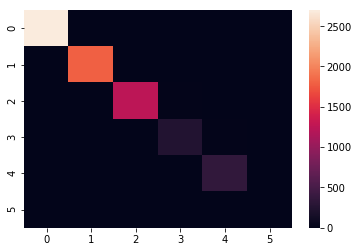

In [5]:
# Print confusion matrix

import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn

y_pred = np.ndarray.flatten(np.argmax(model.predict(map(list,zip(*X_test))), axis=2))
y_true = np.ndarray.flatten(np.argmax(y_test, axis=2))
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred).astype(float)
normalize_confusion = confusion/np.array([np.sum(confusion,axis=1)]).T
sn.heatmap(confusion)
display(confusion.astype(int))

In [241]:
model.count_params()

144

In [ ]:
# Everything after this is trash lol

In [208]:
header_vec = np.zeros(headers_padded[0].shape)
connectivity_graph = connectivies_padded[0]
bondmat = matrices_padded[0]

horiz_repeat = np.repeat(np.expand_dims(header_vec, axis=1), 29, axis=1)
vert_repeat = np.repeat(np.expand_dims(header_vec, axis=0), 29, axis=0)
combined = np.concatenate([horiz_repeat, vert_repeat,bondmat],axis=2)
mystates = np.sum(combined * np.expand_dims(connectivity_graph, axis=2), axis=1)
print (mystates[:,-3]+2*mystates[:,-2]+3*mystates[:,-1]).astype(int)
print np.argmax(headers_padded[0], axis=1)

[2 4 4 2 4 2 4 4 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 2 2 4 2 4 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


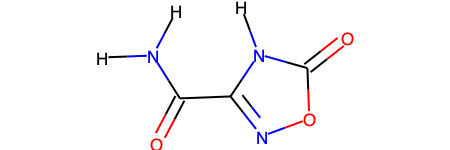

In [205]:
import rdkit.Chem as Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

def fingerprint_to_rdmol(header, bondmat):
    rdmol = Chem.RWMol()
    indices = []
    numAtoms = len(header)
    atomDict = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    for i in header:
        if i != 0:
            indices = indices + [rdmol.AddAtom(Chem.Atom(atomDict[i]))]
    for j in range(numAtoms):
        for k in range(j, numAtoms):
            bondOrder = bondmat[j][k]
            if bondOrder == 7 or bondOrder == 9:
                #print "delocalized or Pi bond... unhandled"
                raise ValueError("delocalized or Pi bond... unhandled")
            bondTypes = Chem.rdchem.BondType
            bondOrders = {1:bondTypes.SINGLE, 2:bondTypes.DOUBLE, 3:bondTypes.TRIPLE,
                          4:bondTypes.QUADRUPLE, 5:bondTypes.AROMATIC, 7:bondTypes.AROMATIC, 9:bondTypes.AROMATIC}
            if bondOrder in bondOrders:
                rdmol.AddBond(indices[j], indices[k], bondOrders[bondOrder])
    return rdmol
fingerprint_to_rdmol(origHeaders_padded[4],origMatrices_padded[4])

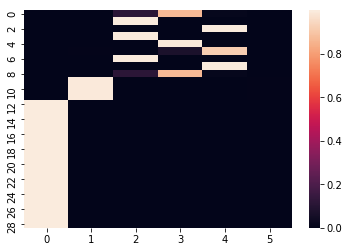

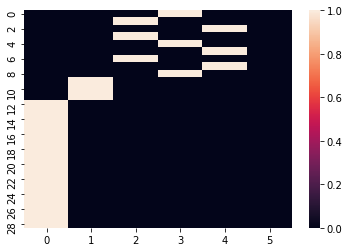

In [212]:
sampleNum = 4
prediction = model.predict([matrices_padded[sampleNum:sampleNum+1], headers_padded[sampleNum:sampleNum+1], connectivies_padded[sampleNum:sampleNum+1]])
sn.heatmap(prediction[0])
plt.figure()
sn.heatmap(headers_padded[sampleNum])

In [243]:
# How good is a "dumb" fully-connected network followed by softmax? Pretty good, it seems...


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(matrices_padded, headers_padded, test_size=0.33)

inputLayer = keras.layers.Input(shape=(29,29,4))
flattenLayer = keras.layers.Flatten()(inputLayer)
denseLayer = keras.layers.Dense(29*6,activation='relu')(flattenLayer)
reshapeLayer = keras.layers.Reshape((29,6))(denseLayer)
choiceLayer = keras.layers.Softmax(axis=2)(reshapeLayer)


model = keras.models.Model(inputs=inputLayer, outputs=choiceLayer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['mean_squared_error', 'mean_absolute_error','categorical_crossentropy'])
print model.count_params()
model.fit(X_train, y_train, epochs=300, verbose=True)



585510
Epoch 1/300


KeyboardInterrupt: 

array([[2596,   32,    0,    0,    0,    0],
       [ 137, 1712,    4,    0,    0,    0],
       [ 485,    1,  807,    8,    0,    0],
       [ 127,    6,   77,   14,   16,    0],
       [ 230,   11,   35,   15,   54,    0],
       [  10,    1,    0,    1,    1,    0]])

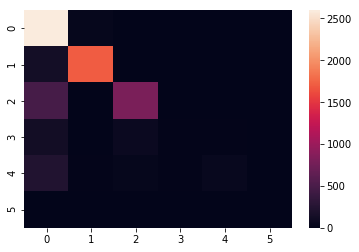

In [214]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn

y_pred = np.ndarray.flatten(np.argmax(model.predict(X_test), axis=2))
y_true = np.ndarray.flatten(np.argmax(y_test, axis=2))
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred).astype(float)
normalize_confusion = confusion/np.array([np.sum(confusion,axis=1)]).T
sn.heatmap(confusion)
display(confusion.astype(int))

array([[8001,  204,    1,    0,    0,    0],
       [2445, 2884,   26,    0,    1,    0],
       [ 477,    1, 3333,    9,    2,    0],
       [ 131,   13,  505,   58,   98,    0],
       [ 239,    2,  244,   13,  567,    0],
       [   8,    0,    6,    0,   17,    0]])

In [190]:
array_cohort = [np.zeros((np.random.randint(5),np.random.randint(5))) for _ in range(200)]


[4, 4]

In [6]:
# A working predictor for ONE graph. Protect this. It works.
# MASTER VERSION.

import os, sys, glob
import numpy as np
import scipy as sp
import copy
import keras

import itertools as it

def readfile(fname):
    def prune(vec, mat, maxsize=15):
        if len(vec) < maxsize:
            old_length = len(vec)
            vec = np.pad(vec, (0, maxsize-old_length), 'constant')
            mat = np.pad(mat, ((0, maxsize-old_length), (0, maxsize-old_length)), 'constant')
            assert len(vec) == maxsize, 'Length of vector not equal to max size - this is an implementation error.'
            assert mat.shape == (maxsize, maxsize), 'Size of matrix not equal to max size - this is an implementation error.'
        assert all([i<maxsize for i,j in enumerate(vec) if j!=0]), 'Vector has nonzero entries after element 15!'
        if len(vec) > maxsize:
            assert np.all(mat.T == mat), 'Matrix is not symmetric - case not handled!'
            assert all(np.any(mat[maxsize:] != 0, 0) == False), 'Some nonzero horizontal rows found outside cutoff!'
        return (vec[:maxsize], mat[:maxsize, :maxsize])

    a = open(fname)
    b = a.readlines()
    a.close()
    csv_as_float_2D = [map(float,i.strip().split(',')) for i in b]
    atom_list = csv_as_float_2D[0]
    bond_orders = csv_as_float_2D[1:]

    atom_vec = np.array(atom_list)
    BO_mat = np.array(bond_orders)
    assert len(np.shape(atom_vec))==1, 'Atom vector is not a flat array!'
    assert np.shape(atom_vec)[0] == np.shape(BO_mat)[0], "Dimensions of atom vector and bond order matrix don't match!"
    assert np.all(BO_mat.T == BO_mat), 'Bond order matrix is not symmetric!'
    try:
        return prune(atom_vec, BO_mat, 29)
    except AssertionError as e:
        print(g)
        print(BO_mat.shape)
        print(e.args)
        return None

def takeFirst(x):
    return x[0]

def separateMe(x):
    guess = x[:,-1:]
    mymatrix = x[:,:-1]
    
    guess_is = keras.backend.repeat_elements(guess,29,1)
    guess_js = keras.backend.repeat_elements(keras.backend.transpose(guess),29,0)
    #edges = keras.backend.cast_to_floatx(mymatrix)
    edges = mymatrix
    bigmat = keras.backend.stack((guess_is, guess_js, edges),2)
    return [guess, mymatrix, bigmat]

def refactorizer(operated):
    new_1d = keras.backend.transpose(keras.backend.sum(operated,1))
    #new_1d = keras.backend.expand_dims(new_1d,axis=0)
    return new_1d

graphlist = glob.glob('qm9graph/*.csv')
vecs_and_matrices = [readfile(g) for g in graphlist]
vecs = [i for i,j in vecs_and_matrices]
matrices = [j for i,j in vecs_and_matrices]

TakeFirst = keras.layers.Lambda(takeFirst)
Separator = keras.layers.Lambda(separateMe)
Refactorizer = keras.layers.Lambda(refactorizer)

inputs = keras.layers.Input(shape=(29,30,), batch_shape=(None,29,30))
firstinput = TakeFirst(inputs)
myvec, mygraph, bigmat = Separator(firstinput)

# M kernel - automatically detects that the input has dimension 3
redonemat = keras.layers.Dense(1)(keras.layers.Dense(3, activation='tanh')(bigmat))

newhidden = Refactorizer(redonemat)

combined_thing_y = np.expand_dims(vecs[0],axis=1)
combined_thing = np.concatenate((matrices[0], combined_thing_y), axis=1)
combined_thing = np.array([combined_thing])

model = keras.models.Model(inputs=inputs, outputs=newhidden)
model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])
model.fit(combined_thing, np.expand_dims(vecs[0], axis=0), epochs=250, batch_size=1)

Epoch 1/250
1/1 [==============================] - 1s 673ms/step - loss: 90.4713 - mean_squared_error: 90.4713 - mean_absolute_error: 8.8135
Epoch 2/250
1/1 [==============================] - 0s 3ms/step - loss: 76.2980 - mean_squared_error: 76.2980 - mean_absolute_error: 8.0571
Epoch 3/250
1/1 [==============================] - 0s 3ms/step - loss: 67.5285 - mean_squared_error: 67.5285 - mean_absolute_error: 7.5781
Epoch 4/250
1/1 [==============================] - 0s 3ms/step - loss: 61.0061 - mean_squared_error: 61.0061 - mean_absolute_error: 7.2016
Epoch 5/250
1/1 [==============================] - 0s 2ms/step - loss: 55.7775 - mean_squared_error: 55.7775 - mean_absolute_error: 6.8856
Epoch 6/250
1/1 [==============================] - 0s 2ms/step - loss: 51.4083 - mean_squared_error: 51.4083 - mean_absolute_error: 6.6101
Epoch 7/250
1/1 [==============================] - 0s 2ms/step - loss: 47.6589 - mean_squared_error: 47.6589 - mean_absolute_error: 6.3641
Epoch 8/250
1/1 [========

Epoch 60/250
1/1 [==============================] - 0s 3ms/step - loss: 3.9639 - mean_squared_error: 3.9639 - mean_absolute_error: 1.7657
Epoch 61/250
1/1 [==============================] - 0s 2ms/step - loss: 3.8105 - mean_squared_error: 3.8105 - mean_absolute_error: 1.7290
Epoch 62/250
1/1 [==============================] - 0s 2ms/step - loss: 3.6634 - mean_squared_error: 3.6634 - mean_absolute_error: 1.6931
Epoch 63/250
1/1 [==============================] - 0s 2ms/step - loss: 3.5223 - mean_squared_error: 3.5223 - mean_absolute_error: 1.6580
Epoch 64/250
1/1 [==============================] - 0s 3ms/step - loss: 3.3871 - mean_squared_error: 3.3871 - mean_absolute_error: 1.6237
Epoch 65/250
1/1 [==============================] - 0s 3ms/step - loss: 3.2574 - mean_squared_error: 3.2574 - mean_absolute_error: 1.5901
Epoch 66/250
1/1 [==============================] - 0s 3ms/step - loss: 3.1330 - mean_squared_error: 3.1330 - mean_absolute_error: 1.5573
Epoch 67/250
1/1 [================

Epoch 120/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4567 - mean_squared_error: 0.4567 - mean_absolute_error: 0.5166
Epoch 121/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4426 - mean_squared_error: 0.4426 - mean_absolute_error: 0.5078
Epoch 122/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4290 - mean_squared_error: 0.4290 - mean_absolute_error: 0.4992
Epoch 123/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4159 - mean_squared_error: 0.4159 - mean_absolute_error: 0.4907
Epoch 124/250
1/1 [==============================] - 0s 3ms/step - loss: 0.4034 - mean_squared_error: 0.4034 - mean_absolute_error: 0.4827
Epoch 125/250
1/1 [==============================] - 0s 3ms/step - loss: 0.3912 - mean_squared_error: 0.3912 - mean_absolute_error: 0.4751
Epoch 126/250
1/1 [==============================] - 0s 3ms/step - loss: 0.3796 - mean_squared_error: 0.3796 - mean_absolute_error: 0.4676
Epoch 127/250
1/1 [========

Epoch 179/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1106 - mean_squared_error: 0.1106 - mean_absolute_error: 0.2359
Epoch 180/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2333
Epoch 181/250
1/1 [==============================] - 0s 3ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - mean_absolute_error: 0.2308
Epoch 182/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1054 - mean_squared_error: 0.1054 - mean_absolute_error: 0.2283
Epoch 183/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1038 - mean_squared_error: 0.1038 - mean_absolute_error: 0.2259
Epoch 184/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2235
Epoch 185/250
1/1 [==============================] - 0s 2ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2211
Epoch 186/250
1/1 [========

Epoch 238/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1385
Epoch 239/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1375
Epoch 240/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.1365
Epoch 241/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - mean_absolute_error: 0.1355
Epoch 242/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1346
Epoch 243/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0553 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1337
Epoch 244/250
1/1 [==============================] - 0s 2ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1327
Epoch 245/250
1/1 [========

In [9]:
combined_thing_y

array([[[8.],
        [6.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [6.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

In [406]:
print(model.predict(combined_thing))
print(model.get_weights())
np.mean(np.abs(model.predict(combined_thing) - np.expand_dims(vecs[0], axis=0)))

[[ 8.799278    5.6296477   5.6296477   8.7966585   5.031527    8.78908
   5.2160206   5.361666    1.3293701   1.3790778   1.3790777   1.3790778
  -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637
  -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637
  -0.07970637 -0.07970637 -0.07970637 -0.07970637 -0.07970637]]
[array([[ 0.7604049 , -1.0607893 , -0.7237089 ],
       [-0.35061258,  0.8058956 ,  0.14019883],
       [-0.41346732,  0.7028782 ,  0.41891006]], dtype=float32), array([ 0.09325026, -0.12081977,  0.03234083], dtype=float32), array([[ 0.42809203],
       [-0.741643  ],
       [ 0.9459558 ]], dtype=float32), array([0.08198211], dtype=float32)]


0.2875213396960291

In [256]:
def reshapeMe(x):
        x = x[0] # Take the first element of x, ignore everything else.
        guess = x[:,-1:]
        mymatrix = x[:,:-1]
        mpassfunc = self.mpassfunc
        self._trainable_weights.append(mpassfunc.trainable_weights)
        #guess, mymatrix, mpassfunc = x # guess refers to the hidden message vector
        guess_is = keras.backend.repeat_elements(guess,29,1)
        guess_js = keras.backend.repeat_elements(keras.backend.transpose(guess),29,0)
        #edges = keras.backend.cast_to_floatx(mymatrix)
        edges = mymatrix
        bigmat = keras.backend.stack((guess_is, guess_js, edges),2)
        operated = mpassfunc(bigmat)
        new_2d = keras.backend.batch_flatten(operated)
        new_1d = keras.backend.sum(new_2d,1)
        
        final_return = keras.backend.concatenate((new_2d, keras.backend.expand_dims(new_1d,axis=1)), axis=1)
        return keras.backend.expand_dims(final_return[:,-1:],axis=0)

    def compute_output_shape(self, input_shape):
        return (None, 29, 1)

AttributeError: 'Sequential' object has no attribute 'kernel'

In [211]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(3, input_shape=(1,)))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
#model.fit([1,2,3,200,1,-4],[1,1,1,1,1,1], epochs=5)
#model.fit([1],[1], epochs=5)
model.predict([1,10,2,20])

array([[0.3228463],
       [3.2284632],
       [0.6456926],
       [6.4569263]], dtype=float32)

In [151]:
a = np.zeros((3,1))
g = np.ones((3,4))
g[:,3] = 2
g[:,-1:]
g[:,:-1]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
# Bad attempt at graph convolution
import os, sys, glob
import numpy as np
import scipy as sp
import copy
import keras

import itertools as it

graphlist = glob.glob('qm9graph/*.csv')
vecs_and_matrices = [readfile(g) for g in graphlist]
vecs = [i for i,j in vecs_and_matrices]
matrices = [j for i,j in vecs_and_matrices]

def readfile(fname):
    a = open(fname)
    b = a.readlines()
    a.close()
    csv_as_float_2D = [map(float,i.strip().split(',')) for i in b]
    atom_list = csv_as_float_2D[0]
    bond_orders = csv_as_float_2D[1:]

    atom_vec = np.array(atom_list)
    BO_mat = np.array(bond_orders)
    assert len(np.shape(atom_vec))==1, 'Atom vector is not a flat array!'
    assert np.shape(atom_vec)[0] == np.shape(BO_mat)[0], "Dimensions of atom vector and bond order matrix don't match!"
    assert np.all(BO_mat.T == BO_mat), 'Bond order matrix is not symmetric!'
    try:
        return prune(atom_vec, BO_mat, 29)
    except AssertionError as e:
        print(g)
        print(BO_mat.shape)
        print(e.args)
        return None

def prune(vec, mat, maxsize=15):
    if len(vec) < maxsize:
        old_length = len(vec)
        vec = np.pad(vec, (0, maxsize-old_length), 'constant')
        mat = np.pad(mat, ((0, maxsize-old_length), (0, maxsize-old_length)), 'constant')
        assert len(vec) == maxsize, 'Length of vector not equal to max size - this is an implementation error.'
        assert mat.shape == (maxsize, maxsize), 'Size of matrix not equal to max size - this is an implementation error.'
    assert all([i<maxsize for i,j in enumerate(vec[0]) if j!=0]), 'Vector has nonzero entries after element 15!'
    if len(vec) > maxsize:
        assert np.all(mat.T == mat), 'Matrix is not symmetric - case not handled!'
        assert all(np.any(mat[maxsize:] != 0, 0) == False), 'Some nonzero horizontal rows found outside cutoff!'
    return (vec[:maxsize], mat[:maxsize, :maxsize])


class Messenger(keras.layers.Layer):
    # Performs message passing with the same M kernel once, without postprocessing. Includes passing to self.
    def __init__(self, mpassfunc, **kwargs):
        #self.mpassfunc = mpassfunc
        self.mpassfunc = mpassfunc
        super(Messenger, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Messenger, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x)
        print(x[0])
        print(x.shape)
        x = x[0] # Take the first element of x, ignore everything else.
        guess = x[:,-1:]
        mymatrix = x[:,:-1]
        mpassfunc = self.mpassfunc
        self._trainable_weights.append(mpassfunc.trainable_weights)
        #guess, mymatrix, mpassfunc = x # guess refers to the hidden message vector
        guess_is = keras.backend.repeat_elements(guess,29,1)
        guess_js = keras.backend.repeat_elements(keras.backend.transpose(guess),29,0)
        #edges = keras.backend.cast_to_floatx(mymatrix)
        edges = mymatrix
        bigmat = keras.backend.stack((guess_is, guess_js, edges),2)
        operated = mpassfunc(bigmat)
        new_2d = keras.backend.batch_flatten(operated)
        new_1d = keras.backend.sum(new_2d,1)
        
        final_return = keras.backend.concatenate((new_2d, keras.backend.expand_dims(new_1d,axis=1)), axis=1)
        return keras.backend.expand_dims(final_return[:,-1:],axis=0)

    def compute_output_shape(self, input_shape):
        return (None, 29, 1)
    


    
labelator = keras.models.Sequential()
labelator.add(keras.layers.Dense(3, input_shape=(3,)))
labelator.add(keras.layers.Dense(1))
labelator.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

inputs = keras.layers.Input(shape=(29,30,))
b = Messenger(mpassfunc=labelator)(inputs)

#b = Messenger()(a)

model = keras.models.Model(inputs=inputs, outputs=b)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

combined_thing_y = np.expand_dims(vecs[0],axis=1)
combined_thing = np.concatenate((matrices[0], combined_thing_y), axis=1)
combined_thing = np.array([combined_thing])
combined_thing_y = np.expand_dims(combined_thing_y, axis=0)

print(combined_thing.shape)
model.fit(combined_thing, combined_thing_y, epochs=5)